In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
import pyesapi
import atexit
import SimpleITK as sitk

In [2]:
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose)

<bound method 'Dispose'>

In [3]:

# แก้ชื่อตรงนี้
patient_id = "5732385"
course_id = "C2"

#############################################
app.ClosePatient()
patient = app.OpenPatientById(patient_id)

course = patient.CoursesLot(course_id)

In [4]:
def plot_dvh(dose_x, volume_y, structure):
    plt.plot(dose_x, volume_y, label = structure.Id)
    
def get_dvh_dose_volume(structure, plan):
    dvh = plan.GetDVHCumulativeData(
        structure,
        pyesapi.DoseValuePresentation.Absolute,
        pyesapi.VolumePresentation.Relative,
        0.01)
    if dvh is not None:
        dose_x = [p.DoseValue.Dose for p in dvh.CurveData]
        volume_y = [p.Volume for p in dvh.CurveData]
    return dvh, np.array(dose_x)/100, np.array(volume_y)


def get_volume_fraction(dose, volume):
    dx = dose[1]-dose[0]
    deriv = np.diff(volume[::-1])[::-1]/dx
    return deriv/np.sum(deriv)

def mld(dose, volume):
    deriv = get_volume_fraction(dose, volume)
    mld = np.sum(deriv*dose[:-1])
    
    return mld

def summary_dvh(dvh):
    print(f"Structure volume is {dvh.Volume}")
    print(f"Max dose is {dvh.MaxDose}")
    print(f"Min dose is {dvh.MinDose}")
    print(f"Mean lung dose is {dvh.MeanDose}")
    print(f"Median lung dose is {dvh.MedianDose}")
    
def generalize_eud(dose, volume):
    n = 0.99
    fraction = get_volume_fraction(dose, volume)
    eud = np.sum(dose[:-1]**(1/n)* fraction )**n
    return eud

def gaussian(t):
    k = 1/np.sqrt(np.pi*2)
    return k*np.exp(-t**2/2)

def ntcp_lyman(dose, volume):
    eud = generalize_eud(dose, volume)
    td50 = 30.8
    m = 0.37

    t = (eud-td50)/(m*td50)
    a = integrate.quad(gaussian, -np.inf, t)[0]

    return a


Start plan VMAT_Eso
---------------------------------------------------
----CTV---CTV_50
----CTV---CTV_54
----GTV---GTVn
----GTV---GTVp
----PTV---PTV_50/25F
Structure volume is 567.724371659823
Max dose is 5785.6 cGy
Min dose is 4236.9 cGy
Mean lung dose is 5122.3 cGy
Median lung dose is 5107.0 cGy
EUD of this structure is:51.22315917443219
NTCP of this structure is:96.34 %
----PTV---PTV_55/25F
Structure volume is 32.13035146568071
Max dose is 5785.6 cGy
Min dose is 5309.5 cGy
Mean lung dose is 5576.3 cGy
Median lung dose is 5591.0 cGy
EUD of this structure is:55.76250046463322
NTCP of this structure is:98.58 %
----ORGAN---Esophagus
Structure volume is 37.023816691671804
Max dose is 5785.6 cGy
Min dose is 137.3 cGy
Mean lung dose is 4325.9 cGy
Median lung dose is 5123.6 cGy
EUD of this structure is:43.316994674862485
NTCP of this structure is:86.4 %
----ORGAN---Heart
Structure volume is 433.52936027794465
Max dose is 5362.7 cGy
Min dose is 80.8 cGy
Mean lung dose is 2344.6 cGy
Median l

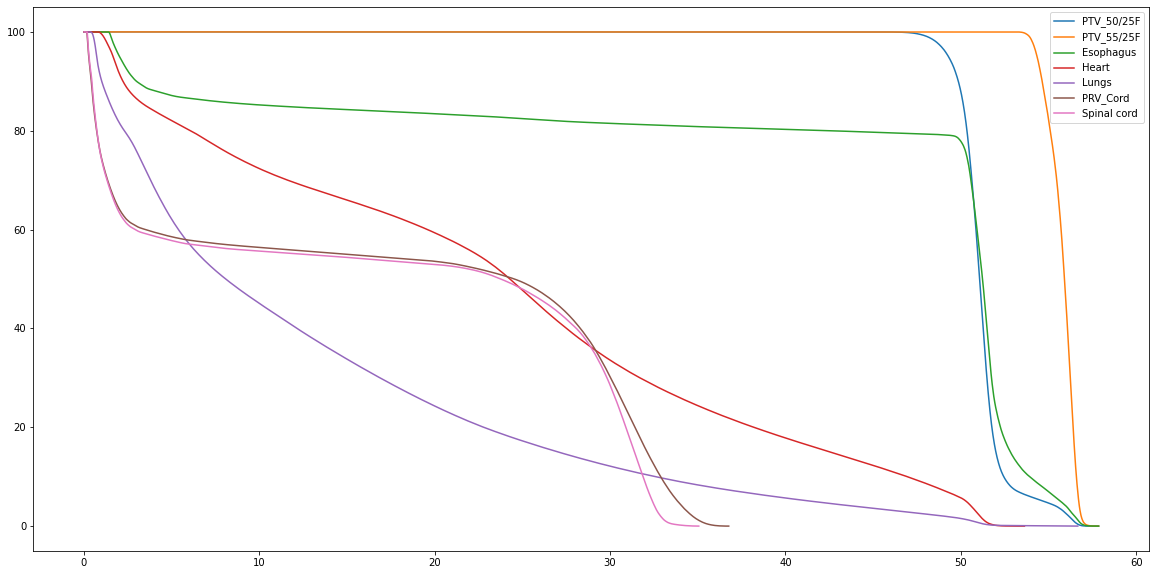

In [5]:

for plan in course.PlanSetups:
    #structure_result = {"structure": [], "dicomtype":[],"value":[]}
    
    print(f"Start plan {plan.Id}")
    print("---------------------------------------------------")
    structures  = plan.StructureSet.Structures
    plt.figure(figsize = (20,10))
    for structure in structures:
        
        
        if structure.DicomType == "ORGAN":

            print(f"----ORGAN---{structure}")
            dvh, x, y = get_dvh_dose_volume(structure, plan)
            summary_dvh(dvh)
            plot_dvh(x,y, structure)
            
            eud = generalize_eud(x, y)
            ntcp = ntcp_lyman(x,y)*100
            
            #structure_result["structure"].append(structure.Id)
            #structure_result["dicomtype"].append(structure.DicomType)
            #structure_result["value"].append(ntcp)
            print(f"EUD of this structure is:{eud}")
            print(f"NTCP of this structure is:{np.round(ntcp,2)} %")
        elif structure.DicomType == "CTV":
            print(f"----CTV---{structure}")
        elif structure.DicomType == "PTV":
            print(f"----PTV---{structure}")
            dvh, x, y = get_dvh_dose_volume(structure, plan)
            summary_dvh(dvh)
            plot_dvh(x,y, structure)
            
            eud = generalize_eud(x, y)
            ntcp = ntcp_lyman(x,y)*100
            
            #structure_result["structure"].append(structure.Id)
            #structure_result["dicomtype"].append(structure.DicomType)
            #structure_result["value"].append(ntcp)
            print(f"EUD of this structure is:{eud}")
            print(f"NTCP of this structure is:{np.round(ntcp,2)} %")
        elif structure.DicomType == "GTV":
            print(f"----GTV---{structure}")
    plt.legend(loc=0)
    plt.show()